# Image Recognition
In this, we will use pre-trained model (AlexNet/VGG16) to retrain on small dataset to classify images using PyTorch.

In [1]:
# Import modules
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
# Import models module to use pre-trained model
from torchvision import datasets, transforms, models

In [2]:
# Define device for torch as GPU to utilize cuda tensor types instead of cpu tensor types
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Apply transformations, first resize numpy array to 224x224, Horizontal flip, shear/scale, adjust coler, convert numpy array to tensor, last normalize using mean and std vectors
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

# Apply transformations, first resize numpy array to 224x224, convert numpy array to tensor, last normalize using mean and std vectors
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
# Load user training dataset and apply image transformations to transform from numpy array to Tensor
training_dataset = datasets.ImageFolder(root='./ants_and_bees/train', transform=transform_train)
# Validation Dataset
validation_dataset = datasets.ImageFolder(root='./ants_and_bees/val', transform=transform)
# Load a batch of 20 shuffled images from dataset to reduce the load on GPU
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
# Validation Dataloader
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

In [4]:
# Convert image from tensor to numpy array for plotting
def im_convert(tensor):
    # Copy tensor and convert to numpy
    image = tensor.clone().detach().numpy()
    # Change 1x28x28 dimensions to 28x28x1
    image = image.transpose(1, 2, 0)
    # De-normalize the image using the same mean and std
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    # To make sure the range of image pixels is between 0 and 1
    image = image.clip(0, 1)
    return image

In [5]:
classes = ('ant', 'bee')

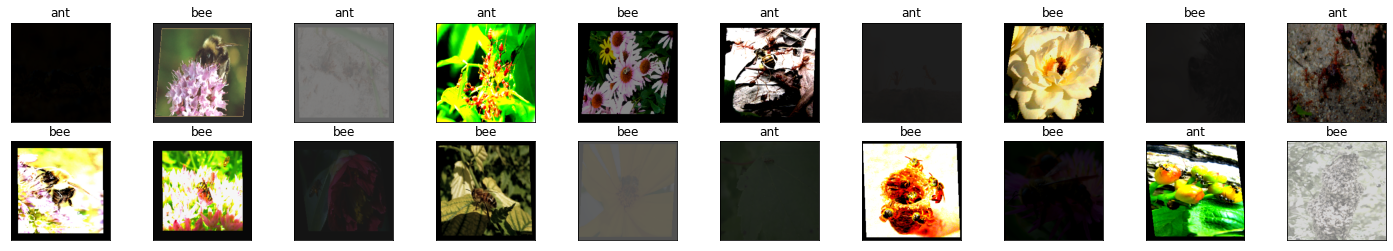

In [6]:
# Iterate through each batch of images
dataiter = iter(training_loader)
# Get first batch of images and labels
images, labels = next(dataiter)
# Create a figure to plot
fig = plt.figure(figsize=(25, 4))
# Plot the first 20 images in 2 row
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [20]:
# Load pre-trained AlexNet model
#model = models.alexnet(pretrained=True)
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/nsanka/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:38<00:00, 14.5MB/s]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inpla

In [21]:
# Freeze features to keep the weights of the pre-trained model in back propagation while training with new dataset
for param in model.features.parameters():
    param.requires_grad = False
# Get the number of input features for last layer
n_inputs = model.classifier[6].in_features
# Update last layer in classifier
model.classifier[6] = nn.Linear(n_inputs, len(classes))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
criterion = nn.CrossEntropyLoss()
# Learning Rate effects the convergence and also accuracy, lower LR needs more epochs to converge, higher LR reduces accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [23]:
epochs = 5
train_losses = []
train_predicts = []
val_losses = []
val_predicts = []
for e in range(epochs):
    train_loss = 0.0
    train_predict = 0.0
    val_loss = 0.0
    val_predict = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the max score for each image in the batch
        _, preds = torch.max(outputs, 1)
        # Compare the max score with actual label value for each image in the batch
        train_predict += torch.sum(preds == labels.data)
        # Append loss for each batch
        train_loss += loss.item()
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model.forward(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                # Get the max score for each image in the batch
                _, val_preds = torch.max(val_outputs, 1)
                # Compare the max score with actual label value for each image in the batch
                val_predict += torch.sum(val_preds == val_labels.data)
                # Append loss for each batch
                val_loss += v_loss.item()

        # Calculate average loss for batch
        train_epoch_loss = train_loss/len(training_loader.dataset)
        # Calculate average accuracy for batch
        train_epoch_acc = train_predict.float()/len(training_dataset)
        train_losses.append(train_epoch_loss)
        train_predicts.append(train_epoch_acc)

         # Calculate average loss for batch
        val_epoch_loss = val_loss/len(validation_loader.dataset)
        # Calculate average accuracy for batch
        val_epoch_acc = val_predict.float()/len(validation_dataset)
        val_losses.append(val_epoch_loss)
        val_predicts.append(val_epoch_acc)
        print('epoch:', (e+1))
        print('training loss {:.4f}, acc {:.4f}'.format(train_epoch_loss, train_epoch_acc.item()))
        print('validation loss {:.4f}, acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss 0.0324, acc 0.6680
validation loss 0.0141, acc 0.9020
epoch: 2
training loss 0.0164, acc 0.8484
validation loss 0.0144, acc 0.9216
epoch: 3
training loss 0.0139, acc 0.8770
validation loss 0.0186, acc 0.9020
epoch: 4
training loss 0.0105, acc 0.9139
validation loss 0.0190, acc 0.9150
epoch: 5
training loss 0.0088, acc 0.9057
validation loss 0.0169, acc 0.9150


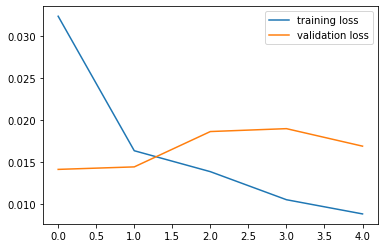

In [24]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

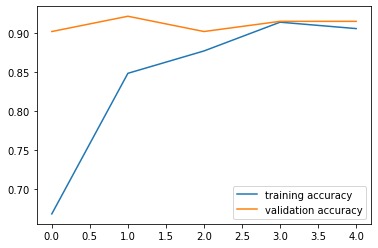

In [25]:
plt.plot(train_predicts, label='training accuracy')
plt.plot(val_predicts, label='validation accuracy')
plt.legend()

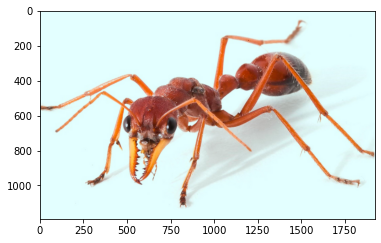

In [26]:
import requests
import PIL
from PIL import Image
url = 'http://cdn.sci-news.com/images/enlarge5/image_6425e-Giant-Red-Bull-Ant.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

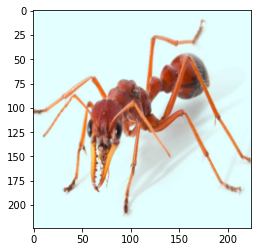

In [27]:
# Transform image: resize 28x28, convert to tensor and normalize
img = transform(img)
plt.imshow(im_convert(img))

In [28]:
# Convert the image to match with model input
inp = img.to(device).unsqueeze(0)
# Predict the digit in the image
output = model.forward(inp)
# Find the index of the max score
val, idx = torch.max(output, 1)
print(val.item(), classes[idx.item()])

10.168829917907715 ant


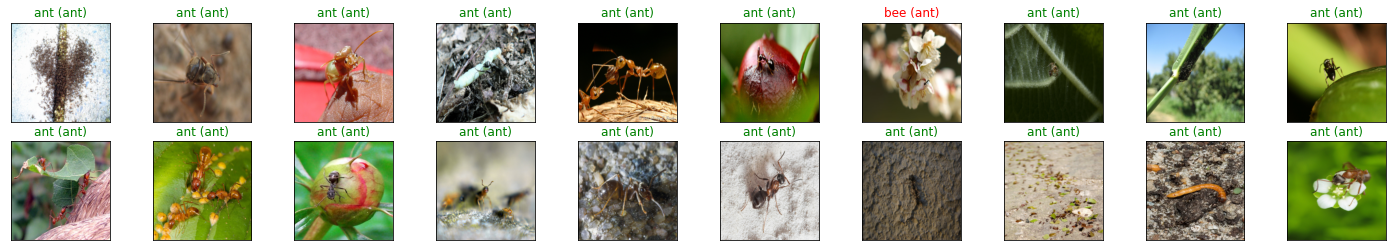

In [29]:
# Iterate through each batch of images
dataiter = iter(validation_loader)
# Get first batch of images and labels
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
vals, preds = torch.max(output, 1)
# Create a figure to plot
fig = plt.figure(figsize=(25, 4))
# Plot the first 20 images in 2 row
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    # convert image tensor to cpu tensor for plotting
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title('{} ({})'.format(classes[preds[idx].item()], classes[labels[idx].item()]), color='green' if (preds[idx] == labels[idx]) else 'red')